In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/trailer-prices/trailerdata1.csv
/kaggle/input/trailer-prices/trailerdata2.csv


# About this notebook
This notebook aims to predict the price of a product (trailer) for an early stage start-up. The data has been anonymized. Due to the web infrastructure of other manufacturers of similar trailers, the data was collected by hand. This project is still on-going and updated regularly. 

## Current Challenges
Currently the challenge is to deal with the small amount of data. There are unfortunately not many data points availbale in general, but more data is still being collected. More features will be added soon :) 

In [2]:
#The trailer price data is saved in a csv file and must first be loaded
data = pd.read_csv('/kaggle/input/trailer-prices/trailerdata2.csv', sep=';')
data.head(5)

,total dry weight,length,exterior width,exterior height,interior height,price
0,1660.0,198.0,102.0,84.0,54.0,14879.0
1,2260.0,194.0,102.0,108.0,74.0,18489.0
2,1320.0,144.0,102.0,90.0,54.0,12500.0
3,1320.0,144.0,102.0,90.0,54.0,14997.0
4,1930.0,185.0,102.0,105.0,73.0,15965.0


In [3]:
#inspect the data types of each column
#for modeling everything needs to be and int or float
data.dtypes

total dry weight    float64
length              float64
exterior width      float64
exterior height     float64
interior height     float64
price               float64
dtype: object

In [4]:
#checking for missing values
#missing values must be dealt with for ML modeling
data.isna().sum()

total dry weight     9
length               9
exterior width      10
exterior height     15
interior height     17
price                9
dtype: int64

For modeling all rows and columns must contain data to be considered "clean". There are numerous empty rows which will be dealt with in various ways coming up.

In [5]:
data

,total dry weight,length,exterior width,exterior height,interior height,price
0,1660.0,198.0,102.0,84.0,54.0,14879.0
1,2260.0,194.0,102.0,108.0,74.0,18489.0
2,1320.0,144.0,102.0,90.0,54.0,12500.0
3,1320.0,144.0,102.0,90.0,54.0,14997.0
4,1930.0,185.0,102.0,105.0,73.0,15965.0
...,...,...,...,...,...,...
91,NaN,NaN,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,NaN,NaN
93,NaN,NaN,NaN,NaN,NaN,NaN
94,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#52 is the target
#everything after is blank rows
data2=data.drop(data.index[87:])

In [7]:
data2.head(5)

,total dry weight,length,exterior width,exterior height,interior height,price
0,1660.0,198.0,102.0,84.0,54.0,14879.0
1,2260.0,194.0,102.0,108.0,74.0,18489.0
2,1320.0,144.0,102.0,90.0,54.0,12500.0
3,1320.0,144.0,102.0,90.0,54.0,14997.0
4,1930.0,185.0,102.0,105.0,73.0,15965.0


In [8]:
data2.isna().sum()

total dry weight    0
length              0
exterior width      1
exterior height     6
interior height     8
price               0
dtype: int64

In [9]:
data2.shape

(87, 6)

In [10]:
#data2 = data1.drop(['model', 'year', 'sleeps', 'aluminum siding (inch)', 'A/C', 'msrp', 'interior height'], axis=1)

In [11]:
#this column will be renamed to get rid of the space
data2 = data2.rename(columns={"exterior height": "eheight", "total dry weight": "tdweight", "interior height":"intheight", "exterior width":"ewidth"})

~~There are still 3 missing values, but it is missing because these trailers are small than all the others and actually don't have an interior to have an interior height. Therefore it makes the most sense to fill them all in with 0, as they must contain some number for modeling.~~
These were edited in the file

In [12]:
#impute null values 
data2['intheight'] = data2['intheight'].fillna(0)
data2['eheight'] = data2['eheight'].fillna(data2['eheight'].mean())
data2['ewidth'] = data2['ewidth'].fillna(data2['ewidth'].mean())

In [13]:
data2

,tdweight,length,ewidth,eheight,intheight,price
0,1660.0,198.0,102.000000,84.00,54.0,14879.0
1,2260.0,194.0,102.000000,108.00,74.0,18489.0
2,1320.0,144.0,102.000000,90.00,54.0,12500.0
3,1320.0,144.0,102.000000,90.00,54.0,14997.0
4,1930.0,185.0,102.000000,105.00,73.0,15965.0
...,...,...,...,...,...,...
82,2200.0,110.0,60.000000,48.00,45.0,38990.0
83,3750.0,156.0,86.000000,63.75,78.0,79990.0
84,640.0,140.0,76.000000,62.00,38.0,9950.0
85,1200.0,157.0,72.000000,64.00,42.0,30590.0


In [14]:
data2.isna().sum()

tdweight     0
length       0
ewidth       0
eheight      0
intheight    0
price        0
dtype: int64

In [15]:
data2.dtypes

tdweight     float64
length       float64
ewidth       float64
eheight      float64
intheight    float64
price        float64
dtype: object

In [16]:
#data2['tdweight'] = data2['tdweight'].astype(float)

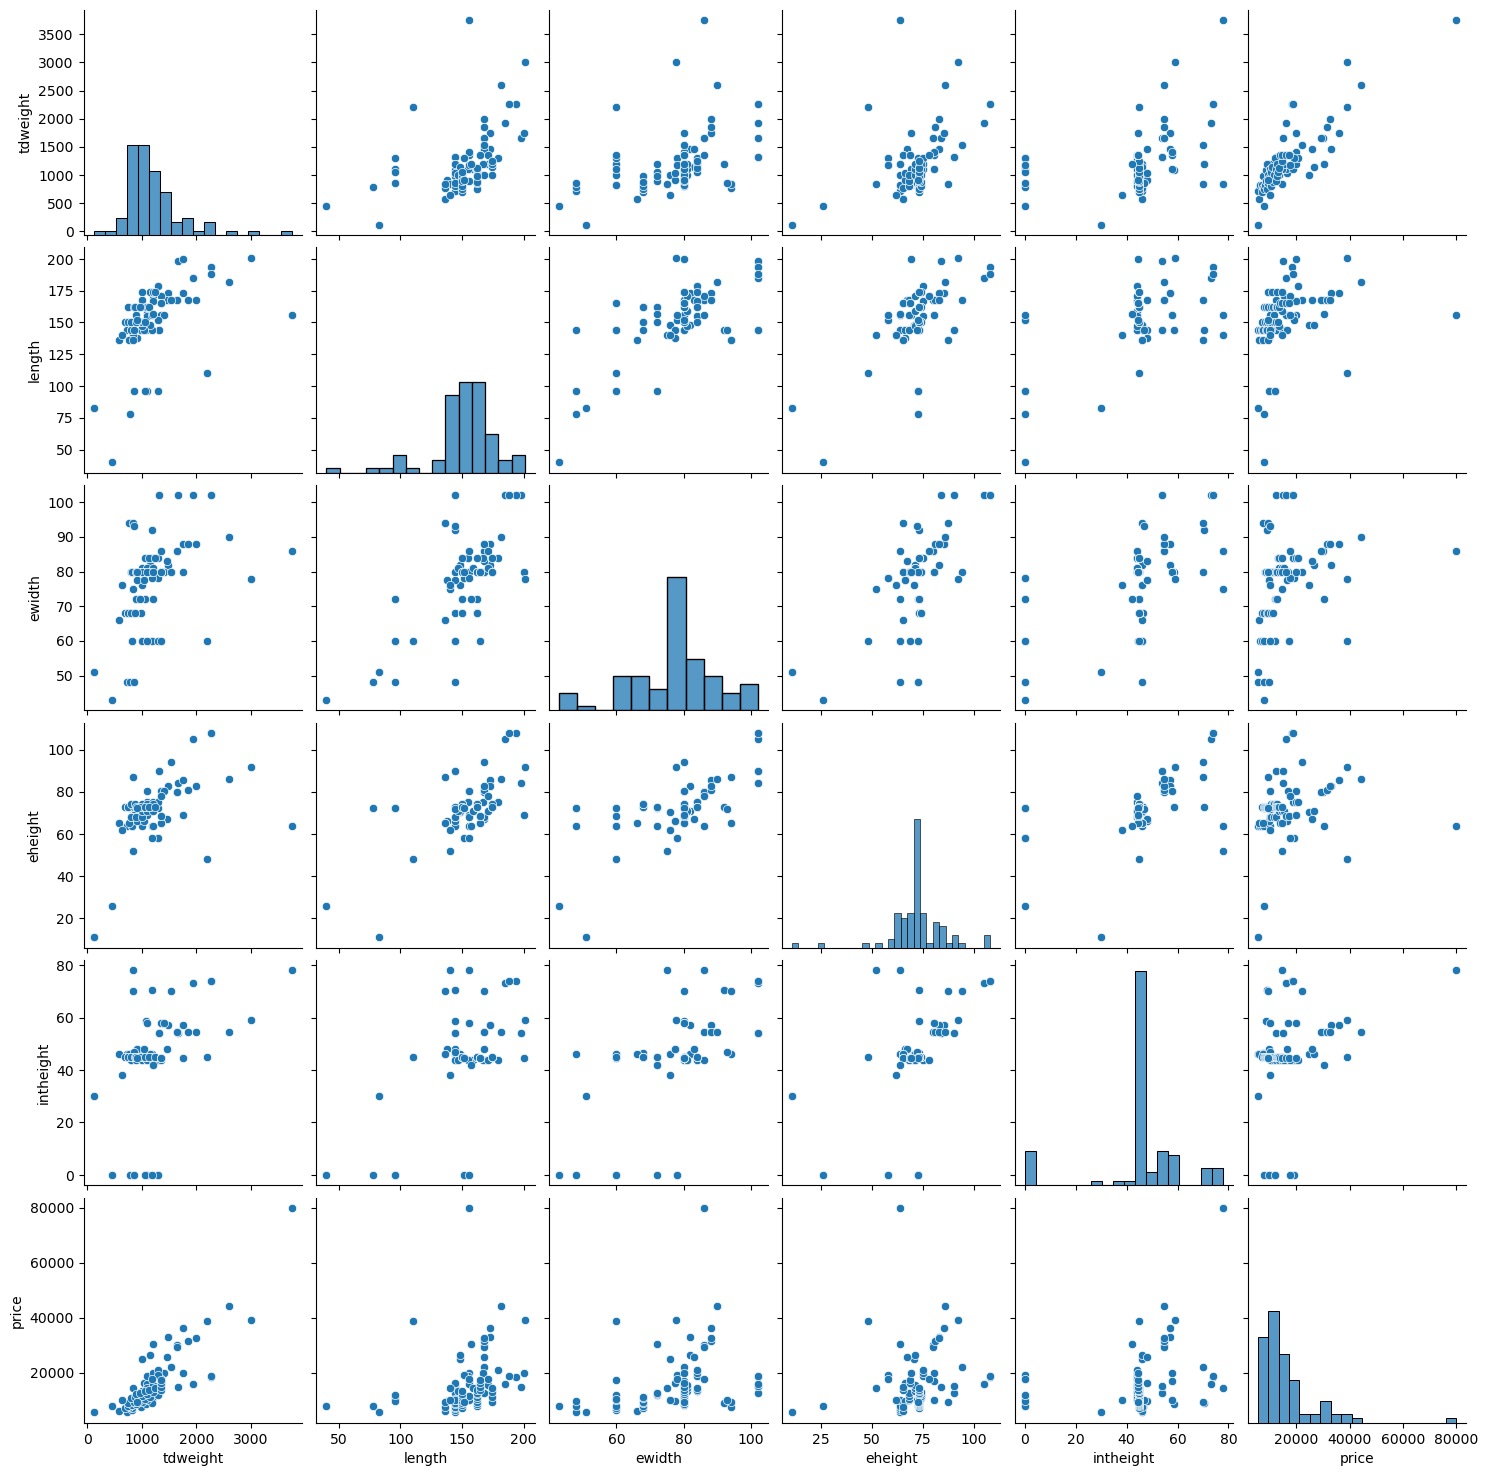

In [17]:
sns.pairplot(data2)

Of all the variables, total dry weight appears to be the most correlated with the price. Let's look at it a bit more closely. 

Text(0.5, 0, 'Price ($)')

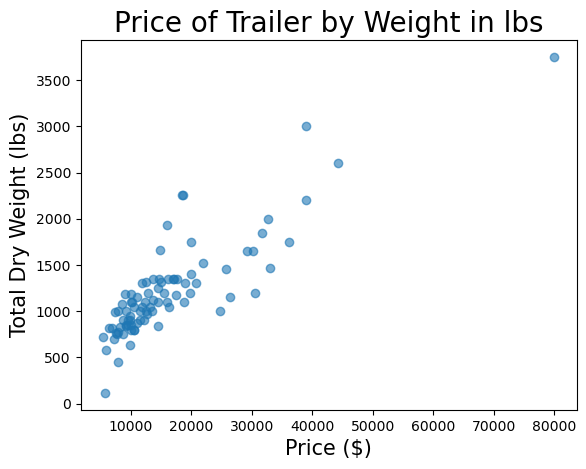

In [18]:
x="price"
y= "tdweight"
plt.scatter(x, y, data=data2, alpha=0.6);
plt.title("Price of Trailer by Weight in lbs", fontsize=20)
plt.ylabel("Total Dry Weight (lbs)", fontsize=15)
plt.xlabel("Price ($)", fontsize=15)
#highlight last point

In [19]:
corr=data2.corr()
corr

,tdweight,length,ewidth,eheight,intheight,price
tdweight,1.000000,0.486464,0.447369,0.471513,0.408638,0.854057
length,0.486464,1.000000,0.647218,0.604059,0.630505,0.310064
ewidth,0.447369,0.647218,1.000000,0.643739,0.589227,0.287664
eheight,0.471513,0.604059,0.643739,1.000000,0.468357,0.178408
intheight,0.408638,0.630505,0.589227,0.468357,1.000000,0.312110
price,0.854057,0.310064,0.287664,0.178408,0.312110,1.000000


<AxesSubplot:>

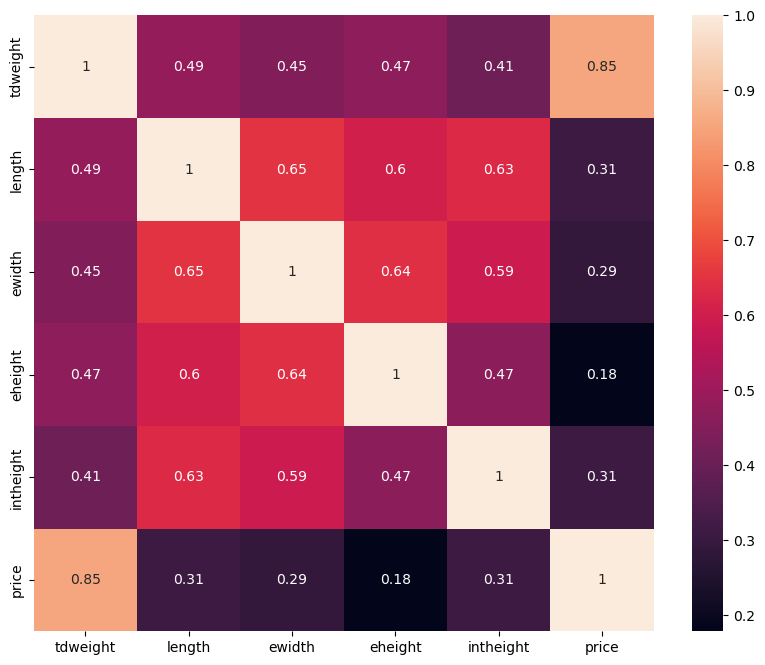

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True)

# Machine Learning Modeling
The data is now clean and we can move forward with creating some machine learning models. Once we settle on the best model it can be used to predict the target price of the trailer in question.

In [21]:
#here the data is split up into X,y where X contains everything but price and y contains what we want to predict (price)
#price is what we want to predict
X = data2.drop(['price'],axis=1)
y=data2['price']

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=1)

In [23]:
#scaling the data
#this usually helps with modeling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
#function which runs different ML models and prints R^2, MAE and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

Now the data is all cleaned up and ready for creating some machine learning models. A funtion has been written to run various models and output metrics 

In [25]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.849702797804907
MAE : 2974.2127649777267
RMSE: 4199.8131967175605


In [26]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.2559953912691034
MAE : 5595.777777777777
RMSE: 9344.204589338111


In [27]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.5378098966385402
MAE : 5527.6864341354685
RMSE: 7364.865953172602


In [28]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.9023774204992092
MAE : 2465.6369147002756
RMSE: 3384.7739135026136


In [29]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.8592747180124155
MAE : 2894.09688919914
RMSE: 4063.8773249104897


In [30]:
model_6 = LassoLars(alpha=.1)
run_experiment(model_6)

R^2 :  0.8498797487047273
MAE : 2973.172352634149
RMSE: 4197.340164683564


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


In [31]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.8671772658240227
MAE : 2821.679633101384
RMSE: 3948.12354118215


In [32]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  0.8614246632563406
MAE : 2883.0580549974734
RMSE: 4032.714688329846


In [33]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  -0.1325521963951266
MAE : 7777.618030429563
RMSE: 11528.787627396434


In [34]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

R^2 :  0.8528473543262977
MAE : 2837.4437872908975
RMSE: 4155.646173953227


At first the Random Forest model was preforming the best, but now it is changing every time new data is added, so more comments will be made later.

## Hyperparameter Tuning
Started this when the Random Forest was working better than other models by far, but now it's clear need to wait until the dataset is more complete.

In [35]:
#rfc=RandomForestRegressor(random_state=1)

In [36]:
#param_grid = { 
#    'n_estimators': [100, 500, 1000, 5000],
#    'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
#    'max_depth' : [5, 10, 15],
#    'min_samples_leaf' : [1,2,3,5],
    #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
#}


In [37]:
#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X_train_scaled, y_train)

In [38]:
#print the best parameters determined in GridSearchCV
#CV_rfc.best_params_

In [39]:
#run a final model using the optimal parameters
#final_model = RandomForestRegressor(n_estimators=5000, max_features='sqrt', max_depth=10, min_samples_leaf=1, random_state=1)
#run_experiment(final_model)

# Making a prediction for the target 

In [40]:
#select the row of the target
new_input = data.iloc[53:54]
new_input

,total dry weight,length,exterior width,exterior height,interior height,price
53,850.0,144.0,93.0,72.0,47.0,9995.0


In [41]:
#drop the variable to be predicted
new_input=new_input.drop(['price'],axis=1)
new_input

,total dry weight,length,exterior width,exterior height,interior height
53,850.0,144.0,93.0,72.0,47.0


In [42]:
#scale the new input
new_input_scaled = scaler.fit_transform(new_input)

In [43]:
#gives prediction in USD
new_output = model_9.predict(new_input_scaled)
new_output

array([13387.31114397])

# Notes on the metrics used
✔️ Regression Evaluation Metrics
Here are three common evaluation metrics for regression problems:

Mean Absolute Error (MAE) is the mean of the absolute value of the errors:
1𝑛∑𝑖=1𝑛|𝑦𝑖−𝑦̂𝑖|
1
n
∑
i
=
1
n
|
y
i
−
y
^
i
|
 

 
Mean Squared Error (MSE) is the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2‾‾‾‾‾‾‾‾‾‾‾‾‾‾⎷
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
📌 Comparing these metrics:

MAE is the easiest to understand, because it's the average error.
MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
All of these are loss functions, because we want to minimize them.

https://www.kaggle.com/code/faressayah/practical-introduction-to-10-regression-algorithm?scriptVersionId=117768677&cellId=36

<iframe src="https://www.kaggle.com/embed/faressayah/practical-introduction-to-10-regression-algorithm?cellIds=36&kernelSessionId=117768677" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Practical Introduction to 10 Regression Algorithm"></iframe>